**ML PROBLEM 5.1**

In [1]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import keras
from keras import *

In [2]:
X_train = np.load(os.path.abspath('Xtrain_Classification1.npy'))
y_train = np.load(os.path.abspath('ytrain_Classification1.npy'))
X_test  = np.load(os.path.abspath('Xtest_Classification1.npy'))

prof da cadeira diz pa usar transfer learning


podemos só usar classificadores do sklearn tipo mlpclassifier, logistic regression, naive bayes, svm

balanced accuracy: (sensitivity + setificity)/2
sensitivity= True positive/(true positvity + false negativity)
setificity = (true negative)/(true neg + false positive)


Use pytorch neural network - harder but most usefull for harder problems (other options are jax and keras)
output layer - 2 neurons is a classification problem - use softmax (if it was 1 neuron it would be regression)



**Neural Network**


In [115]:
def balance_augmentation(x, y):
   
    
    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])
    
    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:           
        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment
    
    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference:
            break
    
    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y


In [117]:
balanced_x, balanced_y = balance_augmentation(X_train,y_train) #dados balanceados (igual entre classes) com augmentation - mesmo nr de melanomas que inicial

In [112]:
def data_augmentation(x, y, augmentation_factor):
    #augmentation_factor is total nr_samples after augmentation / original nr of samples (always >1)
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_train_reshape = np.reshape(x,(x.shape[0],28,28,3))
    data_generator.fit(X_train_reshape)
    #creating arrays of new data/augmented data 
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data
    
  
    for batch_x, batch_y in data_generator.flow(X_train_reshape, y, batch_size=32, seed=500): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] > (x.shape[0])*(augmentation_factor-1): #stops when generated enougth data to satisfy the augmentation factor
            break
            
    
    x_train_aug=np.vstack([x, x_augmented])
    y_train_aug=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return x_train_aug, y_train_aug


In [118]:
augmented_x_train, augmented_y_train = data_augmentation(X_train,y_train, 2) #dados nao balanceados mas aumentados - 2x mais dados
#a fracao de melanoma continua a ser 85% de todos os samples


Epoch 1/130
45/45 [==============================] - 4s 59ms/step - loss: 0.7868 - precision_16: 0.1596 - recall_16: 0.0733 - val_loss: 0.3720 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 2/130
45/45 [==============================] - 3s 59ms/step - loss: 0.3476 - precision_16: 0.5882 - recall_16: 0.0244 - val_loss: 0.3934 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 3/130
45/45 [==============================] - 3s 57ms/step - loss: 0.3298 - precision_16: 0.6195 - recall_16: 0.0855 - val_loss: 0.3267 - val_precision_16: 0.6364 - val_recall_16: 0.0909
Epoch 4/130
45/45 [==============================] - 3s 58ms/step - loss: 0.3101 - precision_16: 0.6368 - recall_16: 0.1563 - val_loss: 0.3447 - val_precision_16: 0.7273 - val_recall_16: 0.1039
Epoch 5/130
45/45 [==============================] - 2s 55ms/step - loss: 0.3231 - precision_16: 0.5907 - recall_16: 0.1392 - val_loss: 0.3383 - val_precision_16: 0.8889 - val_recall_16: 0.1039
Epoch 6/130
45

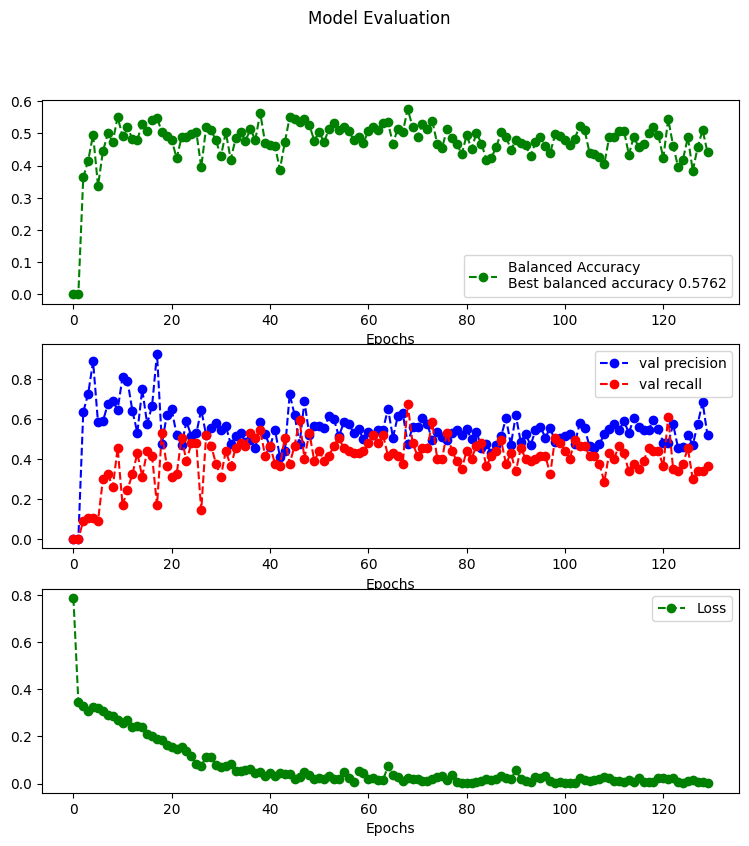

In [144]:
#run all functions before this

#create and run model with image augmentation balanced data
model_balanced, model_history_balanced = neural_defandTrain("adam", "binary_crossentropy" ,130,128,3,3, balanced_x, balanced_y, False)


For image augmentation balanced data
90 epochs 128batch: bba=0.6137, loss on 50 , ba converge on 50, 4.34min , adam, binarycrossentropy, balancedx,y thru augmentation
90 epochs 32 batch: bba=0.5391, loss on 90, ba 20 mas não converge bem, 6.02min, adam, binarycrossentropy, balancedx,y thru augmentation
130epochs 128batch: bba=0.0.5762, loss on 50 , ba converge on 50, 6.23min , adam, binarycrossentropy, balancedx,y thru augmentation

Conclusion: best is 128Batch and 60 epochs should be enought




Epoch 1/130
45/45 [==============================] - 5s 75ms/step - loss: 1.1303 - precision_17: 0.1932 - recall_17: 0.5958 - val_loss: 0.4693 - val_precision_17: 0.2595 - val_recall_17: 0.6234
Epoch 2/130
45/45 [==============================] - 3s 69ms/step - loss: 0.5747 - precision_17: 0.2339 - recall_17: 0.7912 - val_loss: 0.6641 - val_precision_17: 0.2376 - val_recall_17: 0.9351
Epoch 3/130
45/45 [==============================] - 3s 68ms/step - loss: 0.5206 - precision_17: 0.2650 - recall_17: 0.8413 - val_loss: 0.4654 - val_precision_17: 0.2905 - val_recall_17: 0.7922
Epoch 4/130
45/45 [==============================] - 3s 69ms/step - loss: 0.4959 - precision_17: 0.2848 - recall_17: 0.8400 - val_loss: 0.4693 - val_precision_17: 0.2934 - val_recall_17: 0.6364
Epoch 5/130
45/45 [==============================] - 3s 68ms/step - loss: 0.4761 - precision_17: 0.3027 - recall_17: 0.8498 - val_loss: 0.5748 - val_precision_17: 0.2787 - val_recall_17: 0.8831
Epoch 6/130
45/45 [===========

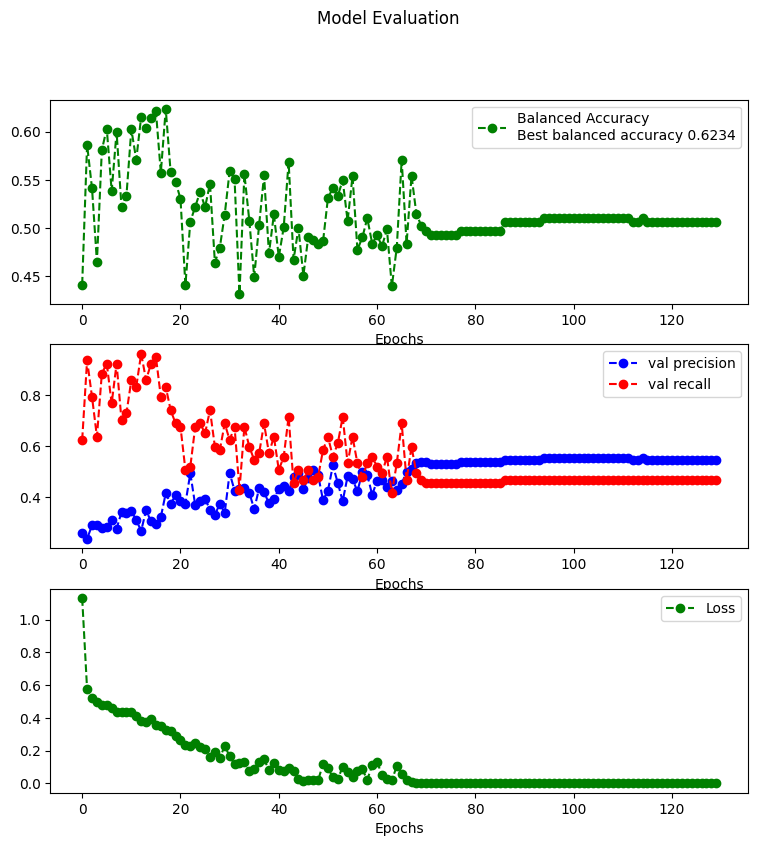

In [145]:
#create and run model without image augmentation balanced data, with class weight balance

model_weighted, model_history_weighted = neural_defandTrain("adam", "binary_crossentropy" ,130,128,3,3, X_train, y_train, True)

90 epochs 128batch: bba=0.611, loss on 70 , ba converge on 80 - bad converge, 4.26min , adam, binarycrossentropy, balanced thru weights no augmentation
130epochs 128batch: bba=not valid 0.62, loss on 70 , ba converge on 90 para 0.52 , 6.36min , adam, binarycrossentropy, balanced thru weights no augmentation

80epochs should be enought

For image augmentation data, with class weight balance
4.20min a 90 128
6.36min a 90 32 - worst results and more time

Conclusion: use bigger batch size once again

Epoch 1/130
45/45 [==============================] - 5s 80ms/step - loss: 0.9557 - precision_18: 0.1969 - recall_18: 0.6032 - val_loss: 0.4288 - val_precision_18: 0.3333 - val_recall_18: 0.5714
Epoch 2/130
45/45 [==============================] - 3s 71ms/step - loss: 0.5412 - precision_18: 0.2577 - recall_18: 0.8217 - val_loss: 0.4200 - val_precision_18: 0.3036 - val_recall_18: 0.6623
Epoch 3/130
45/45 [==============================] - 3s 68ms/step - loss: 0.5056 - precision_18: 0.2821 - recall_18: 0.8254 - val_loss: 0.5761 - val_precision_18: 0.2713 - val_recall_18: 0.9091
Epoch 4/130
45/45 [==============================] - 3s 69ms/step - loss: 0.5104 - precision_18: 0.2653 - recall_18: 0.8535 - val_loss: 0.4746 - val_precision_18: 0.2785 - val_recall_18: 0.7922
Epoch 5/130
45/45 [==============================] - 3s 68ms/step - loss: 0.5016 - precision_18: 0.2778 - recall_18: 0.8681 - val_loss: 0.6610 - val_precision_18: 0.2561 - val_recall_18: 0.9481
Epoch 6/130
45/45 [===========

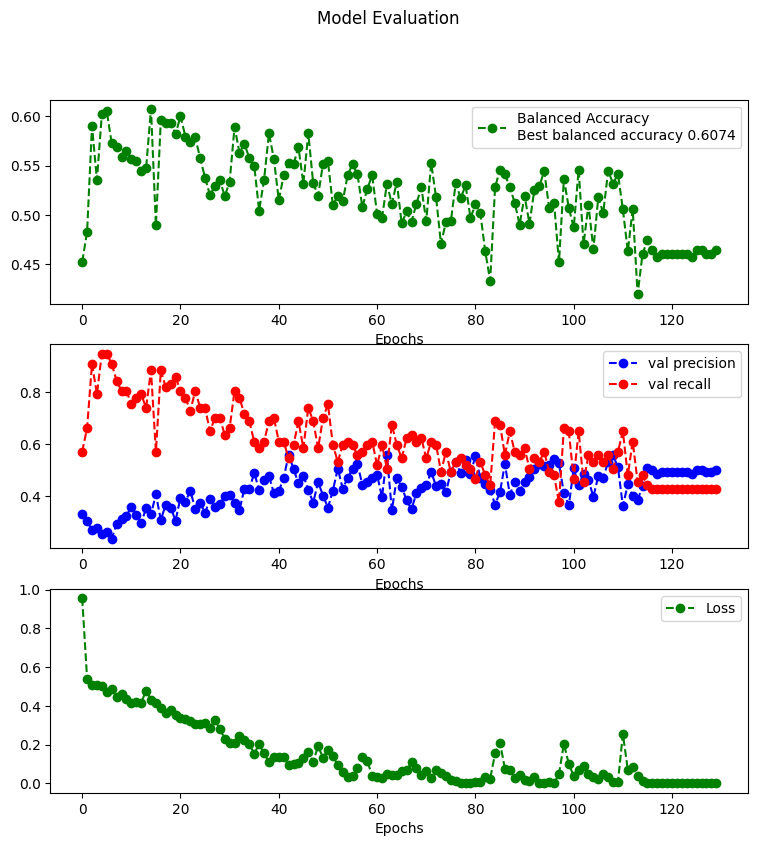

In [146]:
#create and run model with image augmentation data, with class weight balance
model_weighted_augmented, model_history_weighted_augmented = neural_defandTrain("adam", "binary_crossentropy" ,130,128,3,3, augmented_x_train, augmented_y_train, True)

for image augmentation data, with class weight balance
130epochs 128batch: bba=0.6074, loss on 120 , ba converge on 120 - 0.47 , 6.42min , adam, binarycrossentropy, image augmentation data, with class weight balance


Resumo para decidir qual das 3 opções é melhor:

For image augmentation balanced data
    130epochs 128batch: bba=0.0.5762, loss on 50 , ba converge on 50, 6.23min , adam, binarycrossentropy, balancedx,y thru augmentation
for no augmentation and balanced thru weights
    130epochs 128batch: bba=not valid 0.62, loss on 70 , ba converge on 90 para 0.52 , 6.36min , adam, binarycrossentropy, balanced thru weights no augmentation
for image augmentation data, with class weight balance
    130epochs 128batch: bba=0.6074, loss on 120 , ba converge on 120 - 0.47 , 6.42min , adam, binarycrossentropy, image augmentation data, with class weight balance

Resultados mt semelhantes - talvez o melhor seja o só com pesos, sem augmentação

perguntas po prof:  acho que deviamos usar weighted validation?
                    normalizar os pixeis /255
                    
falta:  mudar nr de layers densar e convolucionais
        mudar optimizador
        mudar loss
        

In [130]:
from sklearn.utils import class_weight
def weighted_balance(y_Data):
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_Data) ,y=np.reshape(y_Data, (y_Data.shape[0],)))
    return dict(enumerate(class_weights))


In [68]:

def neural_defandTrain(optimizer_string, loss_string ,epoch_nr,batch,nrconvlayers, nrdesnelayers, x_all, y_all,classweight_bool):

    X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all)
    model = model_def(optimizer_string, loss_string, nrconvlayers, nrdesnelayers)

    if classweight_bool:
        class_weights=weighted_balance(y_all) #calcular pesos de cada classe
    else:
        class_weights =None

    model_history = model.fit(
        X_train_sample,
        y_train_sample,
        batch_size=batch,
        epochs=epoch_nr,
        validation_data=(X_validation, y_validation),# We pass some validation for monitoring validation loss and metrics at the end of each epoch
        class_weight = class_weights)

    best_balancedAccuracy = plot_neuralmodel(model_history)
    save_model(model, model_history, optimizer_string, loss_string ,epoch_nr,batch, best_balancedAccuracy, nrconvlayers, nrdesnelayers)
    return model, model_history


In [136]:
### Neural Network
def model_def(optimizer_string, loss_string, nrconvlayers, nrdesnelayers):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3)))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    for i in range(nrconvlayers-1):
        model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

    #we do not need to use a maxpooling layer after each convolution layer, but it helps reducing computacional load
    if nrconvlayers>4:
        model_img.add(layers.MaxPooling2D(pool_size=(2, 2))) #if we have to many conv layers - a maxpooling is adequado

    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))     #for simple image convolution 2-4 conv layers should be enougth. The number of filters in 
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))                        #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns
    
    #dense layers
    model_img.add(layers.Flatten())
    model_img.add(layers.Dense(256, activation='relu'))
    for i in range(nrdesnelayers-1):
        model_img.add(layers.Dense(64, activation='relu'))
    model_img.add(layers.Dense(1, activation='sigmoid'))
    

    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[keras.metrics.Precision(),keras.metrics.Recall()]
        )

    return model_img



In [46]:

def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy, nrconvlayers, nrdesnelayers ):
    
    #define names for the files
    file_name_model=f"bestbacc_{best_balancedAccuracy}  layers_{nrconvlayers}_{nrdesnelayers}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    #model_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_model)
    file_name_history=f"bestbacc_{best_balancedAccuracy}  layers_{nrconvlayers}_{nrdesnelayers}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    #history_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_history)

    #save the model in a .keras file
    model_fitted.save(file_name_model)
    #save history to numpy array
    np.save(file_name_history,model_history.history)
   

In [134]:
def plot_neuralmodel(model):
    dtf = pd.DataFrame(model.history)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9,9))
    fig.suptitle('Model Evaluation')

    best_bacc =round(max((dtf.iloc[:,4]+dtf.iloc[:,5])/2),4)
   

    ax1.plot((dtf.iloc[:,4]+dtf.iloc[:,5])/2,'go--',label=f'Balanced Accuracy\nBest balanced accuracy {best_bacc}')
    ax1.legend()
    ax1.set_xlabel('Epochs')

    ax2.plot(dtf.iloc[:,4],'bo--',label='val precision')
    ax2.plot(dtf.iloc[:,5],'ro--',label='val recall')
    ax2.legend()
    ax2.set_xlabel('Epochs')


    ax3.plot(dtf.iloc[:,0],'go--',label=f'Loss')
    ax3.legend()
    ax3.set_xlabel('Epochs')

    plt.show()
    return best_bacc


In [139]:
def x_y_preprocessing(x,y):
    X_train_img = np.reshape(X_train,(X_train.shape[0],28,28,3)).copy()
    X_val, X_train_sample = X_train_img[:500].copy(), X_train_img[500:].copy()
    y_val, y_train_sample = y_train[:500].copy(), y_train[500:].copy()

    #only used if softmax is in use
    #y_train_2labels = keras.utils.to_categorical(y_train_sample, num_classes=2)
    #y_val_2labels = keras.utils.to_categorical(y_val, num_classes=2)
    
    
    return X_train_sample, y_train_sample, X_val, y_val

